In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from numpy import absolute

from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential
import keras

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
values = pd.read_csv('Training_values.csv')
labels = pd.read_csv('Training_labels.csv')

In [3]:
df = pd.concat([labels,values], axis=1)

In [4]:
df = df.loc[:,~df.columns.duplicated()]

In [5]:
df.head(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365,Kwa Ngomho,0,...,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Tushirikiane,0,...,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712,Kwa Ramadhan Musa,0,...,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051,Kwapeto,0,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [6]:
df.shape

(59400, 41)

33 categorical 4 continuous

date_recorded  -  object
funder  -  object
installer  -  object
wpt_name  -  object
num_private  -  int64
basin  -  object
subvillage  -  object
region  -  object
region_code  -  int64
district_code  -  int64
lga  -  object
ward  -  object
public_meeting  -  object
recorded_by  -  object
scheme_management  -  object
scheme_name  -  object
permit  -  object
construction_year  -  int64
extraction_type  -  object
extraction_type_group  -  object
extraction_type_class  -  object
management  -  object
management_group  -  object
payment  -  object
payment_type  -  object
water_quality  -  object
quality_group  -  object
quantity  -  object
quantity_group  -  object
source  -  object
source_type  -  object
source_class  -  object
waterpoint_type  -  object
waterpoint_type_group  -  object
status_group  -  object

id  -  int64
amount_tsh  -  float64
longitude  -  float64
latitude  -  float64
population  -  int64


In [7]:
def preprocessing(df):
    print("Preprocessing Data")
    df = df.drop_duplicates()
    #for column in df.columns:
    #    print(column," - ", df[column].dtype)
    df.isna().sum()
    #df.dropna(inplace=True)
    df.isna().sum()

    drop_columns = ["id", "date_recorded", "funder", "installer", "longitude",
                    "latitude", "wpt_name", "region", "region_code",
                    "district_code", "lga", "ward", "recorded_by",
                    "scheme_management", "scheme_name", "construction_year", "extraction_type",
                    "extraction_type_group", "extraction_type_class", "management", "management_group",
                    "payment", "payment_type", "waterpoint_type", "waterpoint_type_group", "subvillage"]


    df.drop(drop_columns, inplace=True, axis=1)
    df.drop('num_private', inplace=True, axis=1)
    
    #for columns in df.columns:
    #    print(columns, " - ", df[columns].dtype)

    return df

In [8]:
def simpleImputer(df):
    print("Using Simple Imputer to handle missing data")

    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent', add_indicator=True)

    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = imputer.fit_transform(df[column].values.reshape(-1,1))
    return df

In [9]:
def visualisation(df):
    print("Visualising data")
    df.plot(kind='box', subplots = True, layout = (24,5), figsize = (30,40))
    
    df = df.drop(df[(np.absolute(df['latitude']) <= 1) &
                 (np.absolute(df['longitude']) <= 1)].index)
    
    map_img = plt.imread('map.jpg')


    plot = sns.scatterplot(data=df, y='longitude', x='latitude',
                        hue='status_group', palette='colorblind', alpha=0.6, zorder=2)

    plot.imshow(map_img,
                aspect=plot.get_aspect(),
                extent=plot.get_xlim() + plot.get_ylim(),
                zorder=1)

    sns.countplot(data = df, x = 'status_group')
    

In [10]:
def labelEncoding(df):
    print("Using Label Encoder to handle string data")
    from keras.utils import np_utils
    from sklearn.preprocessing import LabelEncoder

    encoder_1 = LabelEncoder()
    label_columns = ['quantity_group', 'quality_group']

    df_new = df.copy()

    labels = {}

    for column in df.columns:
        if column in label_columns:
            df_new[column] = encoder_1.fit_transform(df[column].values)
            labels[column] = encoder_1.classes_

    graph = sns.barplot(data=df_new, x='quantity_group',
                        y='quality_group', hue='status_group')
    graph.set_xticklabels(labels['quantity_group'])
    graph.set_yticklabels(labels['quality_group'])

    from sklearn.preprocessing import LabelEncoder

    encoder = LabelEncoder()
    #label_columns = ['basin','public_health','permit','water_quality','quantity','quantity_group','quality','quality_group','source','source_type','source_class']

    df['status_group'] = encoder.fit_transform(df['status_group'].values)
    y = np_utils.to_categorical(df['status_group'])

    for column in df.columns:
        if str(df[column].dtype) == "object":
            df[column] = encoder.fit_transform(df[column].values)
    
    df.head(10)
    
    return df, y

In [11]:
#sns.heatmap(data=df_new, x='quantity_group', y='quality_group', hue='status_group')

In [12]:
def minMaxScaler(df):
    print("Using Min Max Scaler to Normalise the continuous data")

    normalize_columns = ["amount_tsh", "gps_height", "population"]

    for column in normalize_columns:
        df[column] = (df[column] - min(df[column])) / (max(df[column]) - min(df[column]))
    
    return df


In [13]:
def feature_selection_correlation(df):
    print("Using Pearson Correlation for feature selection")
    
    sns.heatmap(df.corr('pearson'))

    correlations = df.corr('pearson')

    corr_df = correlations[-1:]

    print(corr_df)

    fig, ax = plt.subplots(figsize=(120, 1))
    sns.heatmap(corr_df, annot=True, ax=ax)
    
    threshold = 0.01

    columns = list(corr_df.columns.values)
    row = corr_df.iloc[0]

    #test_columns = []

    #for column in columns:
    #    if absolute(corr_df.iloc[0][column]) < threshold:
    #        df.drop([column], axis=1, inplace=True)
    #    else:
    #        test_columns.append(column)
    #print(test_columns)
    
    return df


In [14]:
def sequential_model(X_train, X_test, y_train, y_test):
    print("Sequential Model")
    model = Sequential()
    model.add(Dense(1000, activation='sigmoid', input_shape=(X_train.shape[1],)))
    model.add(Dense(500, activation='sigmoid'))
    model.add(Dense(250, activation='sigmoid'))
    model.add(Dense(200, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(25, activation='sigmoid'))
    model.add(Dense(3, activation='softmax'))

    es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                    mode='min',
                                    patience=10,
                                    restore_best_weights=True)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, batch_size=128, epochs=500, shuffle=True, verbose=2)
    
    y_pred = model.predict(X_test)

    for y in y_pred:
        for i in range(len(y)):
            if y[i] > 0.5:
                y[i] = 1
            else:
                y[i] = 0
    
    return y_pred

In [15]:
def XGBoost(X_train, X_test, y_train, y_test):
    print("XGBoost Model")
    model = xgb.XGBClassifier(objective = 'multi:softprob', random_state = 1, n_estimators = 200, max_depth = 5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(y_pred)
    
    return y_pred
    

In [16]:
def AdaBoost(X_train, X_test, y_train, y_test):
    print("ADABoost Model")
    parameters = {
        'n_estimators':[i for i in range(100,1000,100)],
        'learning_rate':[i*0.1 for i in range(1,10,1)]
    }
    model = AdaBoostClassifier(random_state=0)
    ada = GridSearchCV(model, parameters)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    print(y_pred)
    print(ada.cv_results_)
    
    return y_pred

In [17]:
def GradientBoost(X_train, X_test, y_train, y_test):
    print("Gradient Boost Model")
    parameters = {
        'n_estimators': [i for i in range(100, 1000, 100)],
        'learning_rate': [i*0.1 for i in range(1, 10, 1)],
        'criterion': ['friedman_mse', 'squared_error']
    }
    model = GradientBoostingClassifier()
    gb = GridSearchCV(model, parameters)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    print(y_pred)
    print(gb.cv_results_)

    return y_pred


In [18]:
def Report(y_test, y_pred):
    print("Generating Report")
    from sklearn.metrics import classification_report, confusion_matrix

    labels = ['0', '1', '2']

    report = classification_report(y_test, y_pred, target_names=labels)

    return report

Visualising data


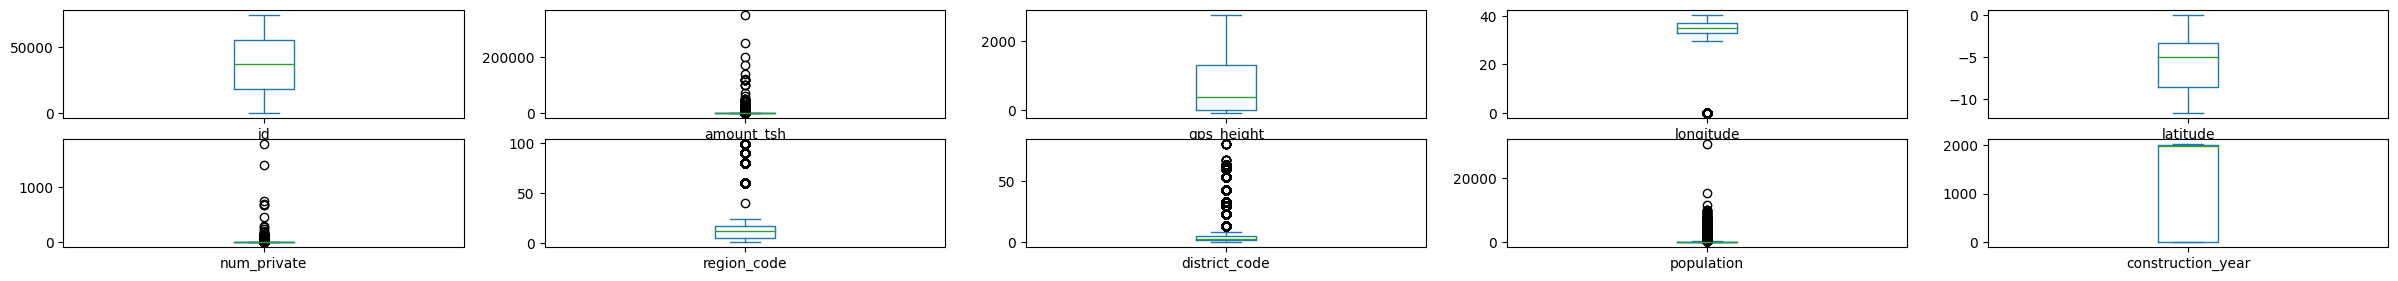

In [19]:
visualisation(df)

In [20]:
def Approach_1(df):
    df = preprocessing(df)
    df = simpleImputer(df)
    df, y = labelEncoding(df)
    df = minMaxScaler(df)
    df = feature_selection_correlation(df)
    
    X = df.drop('status_group', axis=1)
    y = df['status_group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)
    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_pred = XGBoost(X_train, X_test, y_train, y_test)
    report = Report(y_test, y_pred)
    print(report)


In [21]:
def Approach_2(df):
    df = preprocessing(df)
    df = simpleImputer(df)
    df, y = labelEncoding(df)
    df = minMaxScaler(df)
    df = feature_selection_correlation(df)

    X = df.drop('status_group', axis=1)
    y = df['status_group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_pred = AdaBoost(X_train, X_test, y_train, y_test)
    report = Report(y_test, y_pred)
    print(report)


In [22]:
def Approach_3(df):
    df = preprocessing(df)
    df = simpleImputer(df)
    df, y = labelEncoding(df)
    df = minMaxScaler(df)
    df = feature_selection_correlation(df)

    X = df.drop('status_group', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_pred = sequential_model(X_train, X_test, y_train, y_test)
    report = Report(y_test, y_pred)
    print(report)


In [23]:
def Approach_4(df):
    df = preprocessing(df)
    df = simpleImputer(df)
    df, y = labelEncoding(df)
    df = minMaxScaler(df)
    df = feature_selection_correlation(df)

    X = df.drop('status_group', axis=1)
    y = df['status_group']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True)
    print(X.shape)
    print(y.shape)
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    y_pred = GradientBoost(X_train, X_test, y_train, y_test)
    report = Report(y_test, y_pred)
    print(report)


Preprocessing Data
Using Simple Imputer to handle missing data
Using Label Encoder to handle string data


C:\Users\prash\AppData\Local\Temp\ipykernel_25164\2057748063.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels(labels['quality_group'])


Using Min Max Scaler to Normalise the continuous data
Using Pearson Correlation for feature selection
              amount_tsh  gps_height     basin  population  public_meeting  \
status_group   -0.066512   -0.188173  0.034302    0.006193       -0.075405   

                permit  water_quality  quality_group  quantity  \
status_group -0.062587       0.006284       0.134492 -0.153495   

              quantity_group    source  source_type  source_class  \
status_group       -0.153495 -0.165059    -0.142185      0.000107   

              status_group  
status_group           1.0  
(27813, 13)
(27813,)
(22250, 13)
(22250,)
(5563, 13)
(5563,)
XGBoost Model
[0 0 2 ... 0 0 2]
Generating Report
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      3228
           1       0.53      0.20      0.29       400
           2       0.79      0.66      0.72      1935

    accuracy                           0.77      5563
   macro avg       0.70     

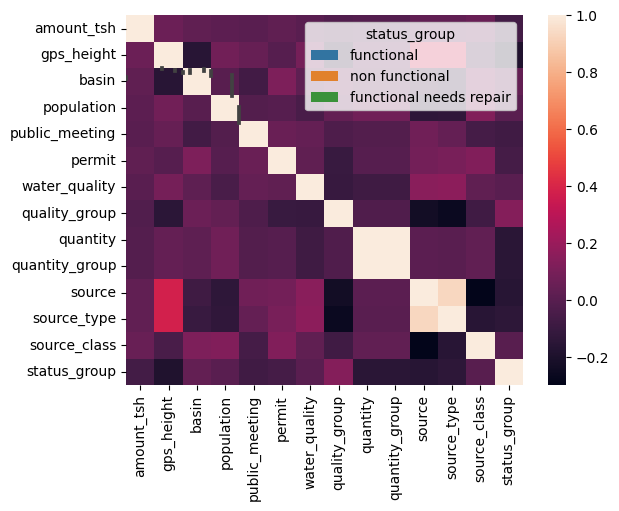

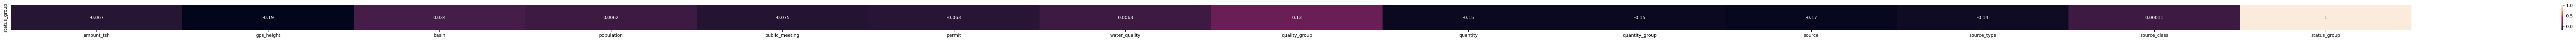

In [24]:
Approach_1(df)

Preprocessing Data
Using Simple Imputer to handle missing data
Using Label Encoder to handle string data


C:\Users\prash\AppData\Local\Temp\ipykernel_25164\2057748063.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels(labels['quality_group'])


Using Min Max Scaler to Normalise the continuous data
Using Pearson Correlation for feature selection
              amount_tsh  gps_height     basin  population  public_meeting  \
status_group   -0.066512   -0.188173  0.034302    0.006193       -0.075405   

                permit  water_quality  quality_group  quantity  \
status_group -0.062587       0.006284       0.134492 -0.153495   

              quantity_group    source  source_type  source_class  \
status_group       -0.153495 -0.165059    -0.142185      0.000107   

              status_group  
status_group           1.0  
(27813, 13)
(27813,)
(22250, 13)
(22250,)
(5563, 13)
(5563,)
ADABoost Model
[0 0 0 ... 2 2 2]
{'mean_fit_time': array([0.91373243, 1.86131911, 2.82158031, 3.73383727, 4.57581468,
       5.50892487, 6.46262503, 7.30069523, 8.03456969, 0.93533521,
       1.84387779, 2.77796245, 3.69791355, 4.46076455, 5.33237743,
       6.21147013, 7.11347647, 8.09401374, 1.00979266, 1.84177012,
       2.67297688, 3.58747272, 

c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

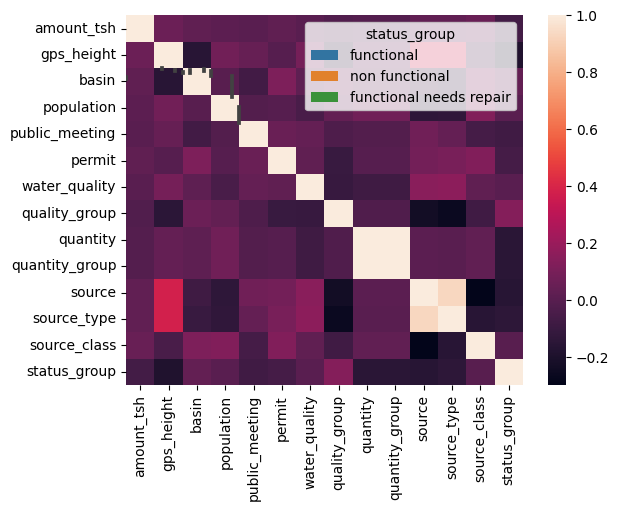

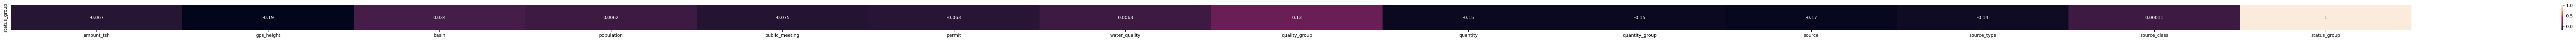

In [25]:
Approach_2(df)

Preprocessing Data
Using Simple Imputer to handle missing data
Using Label Encoder to handle string data


C:\Users\prash\AppData\Local\Temp\ipykernel_25164\2057748063.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels(labels['quality_group'])


Using Min Max Scaler to Normalise the continuous data
Using Pearson Correlation for feature selection
              amount_tsh  gps_height     basin  population  public_meeting  \
status_group   -0.066512   -0.188173  0.034302    0.006193       -0.075405   

                permit  water_quality  quality_group  quantity  \
status_group -0.062587       0.006284       0.134492 -0.153495   

              quantity_group    source  source_type  source_class  \
status_group       -0.153495 -0.165059    -0.142185      0.000107   

              status_group  
status_group           1.0  
(27813, 13)
(27813, 3)
(22250, 13)
(22250, 3)
(5563, 13)
(5563, 3)
Sequential Model
Epoch 1/500
174/174 - 1s - loss: 0.8783 - accuracy: 0.5759 - 1s/epoch - 8ms/step
Epoch 2/500
174/174 - 1s - loss: 0.8759 - accuracy: 0.5779 - 1s/epoch - 6ms/step
Epoch 3/500
174/174 - 1s - loss: 0.8475 - accuracy: 0.6142 - 1s/epoch - 6ms/step
Epoch 4/500
174/174 - 1s - loss: 0.8058 - accuracy: 0.6652 - 1s/epoch - 6ms/step
Epo

c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


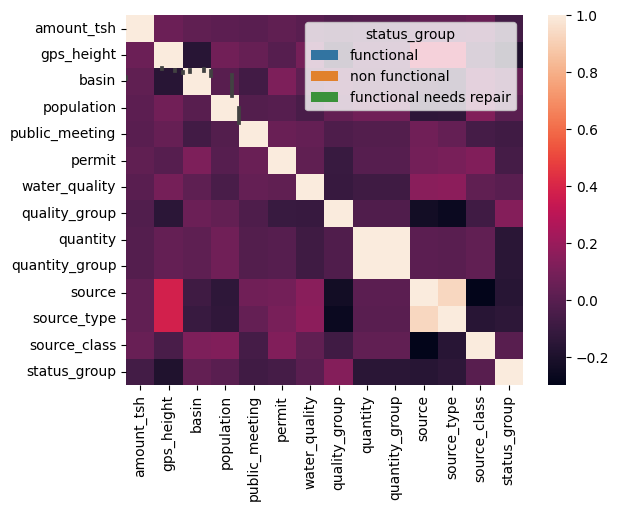

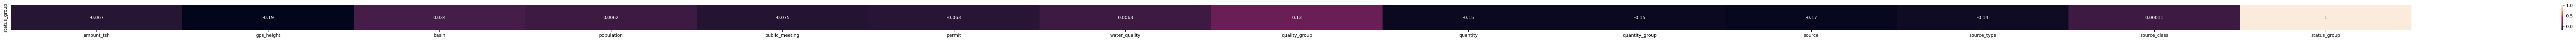

In [26]:
Approach_3(df)

In [27]:
Approach_4(df)

Preprocessing Data
Using Simple Imputer to handle missing data
Using Label Encoder to handle string data


C:\Users\prash\AppData\Local\Temp\ipykernel_25164\2057748063.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels(labels['quality_group'])


Using Min Max Scaler to Normalise the continuous data
Using Pearson Correlation for feature selection
              amount_tsh  gps_height     basin  population  public_meeting  \
status_group   -0.066512   -0.188173  0.034302    0.006193       -0.075405   

                permit  water_quality  quality_group  quantity  \
status_group -0.062587       0.006284       0.134492 -0.153495   

              quantity_group    source  source_type  source_class  \
status_group       -0.153495 -0.165059    -0.142185      0.000107   

              status_group  
status_group           1.0  
(27813, 13)
(27813,)
(22250, 13)
(22250,)
(5563, 13)
(5563,)
Gradient Boost Model


In [ ]:
#X = np.array(X)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6350
           1       0.54      0.09      0.15       890
           2       0.75      0.57      0.64      4640

   micro avg       0.71      0.66      0.69     11880
   macro avg       0.66      0.49      0.52     11880
weighted avg       0.71      0.66      0.67     11880
 samples avg       0.66      0.66      0.66     11880

              precision    recall  f1-score   support

           0       0.70      0.82      0.76      6404
           1       0.49      0.09      0.15       844
           2       0.77      0.52      0.63      4632

   micro avg       0.72      0.65      0.68     11880
   macro avg       0.65      0.48      0.51     11880
weighted avg       0.71      0.65      0.66     11880
 samples avg       0.65      0.65      0.65     11880

              precision    recall  f1-score   support

           0       0.72      0.82      0.77      6469
           1       0.40      0.11      0.18       839
           2       0.77      0.59      0.67      4572

   micro avg       0.73      0.68      0.70     11880
   macro avg       0.63      0.51      0.54     11880
weighted avg       0.72      0.68      0.69     11880
 samples avg       0.68      0.68      0.68     11880